# PISCES wavelength calibration

We have PISCES VARIA calibration sets. We will show how to process them to build a new wavelength calibration

In [1]:
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Import crispy-related stuff

In [2]:
import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.tools.image import Image
from crispy.PISCESparams import Params
codefolder = '../../../crispy'
par = Params(codefolder)

## Build wavelength calibration files

In [3]:
# We need to run the calibration for the first time
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
buildcalibrations(par,
                    inspect=True,
                    genwavelengthsol=True, # Compute wavelength at the center of all pixels
                    makehiresPSFlets=True, # this requires very high SNR on the monochromatic frames
                    makePolychrome=True,   # This is needed to use least squares extraction
                    upsample=3,            # upsampling factor of the high-resolution PSFLets
                    nsubarr=4,             # the detector is divided into nsubarr^2 regions for PSFLet averaging
                    apodize=False,          # to match PSFlet spot locations, only use the inner circular part of the 
                                           #detector, hence discarding the corners of the detector where lenslets are 
                                           #distorted
                  ) 

crispy - INFO - Building calibration files, placing results in ../../../crispy/ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Initializing PSFlet location transformation coefficients
crispy - INFO - Performing initial optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det615.0.fits
crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ../../..

In [4]:
#par.lamlist = np.arange(615.,720.,10)

from crispy.tools.reduction import calculateWaveList
lam_midpts,lam_endpts = calculateWaveList(par,method='lstsq')
print('Wavelengths at midpoints for lstsq (nm): ',lam_midpts)
print('Wavelengths at endpoints for lstsq (nm): ',lam_endpts)
lam_midpts,lam_endpts = calculateWaveList(par,method='optext')
print('Wavelengths at midpoints for optext (nm): ',lam_midpts)
print('Wavelengths at endpoints for optext (nm): ',lam_endpts)

crispy - INFO - Reduced cube will have 11 wavelength bins
('Wavelengths at midpoints for lstsq (nm): ', array([ 610.45454545,  621.36363636,  632.27272727,  643.18181818,
        654.09090909,  665.        ,  675.90909091,  686.81818182,
        697.72727273,  708.63636364,  719.54545455]))
('Wavelengths at endpoints for lstsq (nm): ', array([ 605.        ,  615.90909091,  626.81818182,  637.72727273,
        648.63636364,  659.54545455,  670.45454545,  681.36363636,
        692.27272727,  703.18181818,  714.09090909,  725.        ]))
crispy - INFO - Reduced cube will have 26 wavelength bins
('Wavelengths at midpoints for optext (nm): ', array([ 607.30769231,  611.92307692,  616.53846154,  621.15384615,
        625.76923077,  630.38461538,  635.        ,  639.61538462,
        644.23076923,  648.84615385,  653.46153846,  658.07692308,
        662.69230769,  667.30769231,  671.92307692,  676.53846154,
        681.15384615,  685.76923077,  690.38461538,  695.        ,
        699.6153846

## Monochromatic updates

In [5]:
from crispy.tools.wavecal import monochromatic_update
from crispy.tools.image import Image
# let's pretend that we got a new file
# inImage = Image(par.codeRoot+"/Inputs/Flat637.fits")
# inLam = 637.
inImage = Image(par.wavecalDir+'det685.0.fits')
inLam=685.

# this adjusts the wavecal
monochromatic_update(par,inImage,inLam,apodize=True)
# but you still have to re-run buildcalibrations each time
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
buildcalibrations(par,
                    inspect=True,
                    genwavelengthsol=False, # already done before
                    makehiresPSFlets=False, # already done
                    makePolychrome=True, # update the polychrome with the new wavecal!
                    upsample=3,
                    nsubarr=4
                 )




crispy - INFO - Read data from HDU 1 of ../../../crispy/ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - Making copies of wavelength solution from ../../../crispy/ReferenceFiles/Calibra_170425//lamsol.dat
crispy - INFO - Generating new wavelength solution
crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ../../../crispy/ReferenceFiles/Calibra_170425/det685.0.fits
crispy - INFO - -0.02: x-shift from archival spot positions (pixels)
crispy - INFO - 0.00: y-shift from archival spot positions (pixels)
crispy - INFO - -0.00: rotation from archival spot positions (degrees)
crispy - INFO - Overwriting old wavecal
crispy - INFO - Don't forget to run buildcalibrations again with makePolychrome=True!
crispy - INFO - Building calibration files, placing results in ../../../crispy/ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ../../..

In [6]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image

cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='optext',smoothbad=True) # smoothbad=True is the default
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/Flat637.fits",method='lstsq')
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq')
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='optext')
cube = reduceIFSMap(par,par.wavecalDir+"det655.0.fits",method='lstsq')

# reduce an array directly instead of a FITS file
cube_array = Image(filename= par.wavecalDir+"det655.0.fits").data

# now cube_array is a simple 2D array. Function is the same, but the argument is changed from a string to an array.
# You can also specify name="my_name" in the arguments, and it will output a file called "my_name_red_optext.fits"
# If name is unspecified, it creates a file with the date and time as a base, result of the function
# time.strftime("%Y%m%d-%H%M%S")
cube = reduceIFSMap(par,cube_array,method='lstsq')


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/Flat637.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/Flat637_red_optext.fits
crispy - INFO - Elapsed time: 1.517463s
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/Flat637.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/Flat637_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/Flat637_red_lstsq_resid.fits
crispy - INFO - Elapsed time: 3.655514s
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Elapsed time: 3.632795s
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits

# Construct lenslet bad pixel/flatfield from broadband reduced cube

The following only works if the reduced cube is first done WITHOUT already correcting for lenslet flatfield. To do this, run the but only AFTER running deleting the keywords in the parameters class:

In [5]:
from crispy.IFS import reduceIFSMap

if hasattr(par,'lenslet_flat'): del par.lenslet_flat
if hasattr(par,'lenslet_mask'): del par.lenslet_mask
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq',smoothbad=False)


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Elapsed time: 4.253152s


crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/BB_red_lstsq.fits
('Mean, sig in central 20 lenslets:', 4516.6377, 243.07701)
crispy - INFO - Writing data to ../../../crispy/SimResults/lenslet_flat.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/lenslet_mask.fits


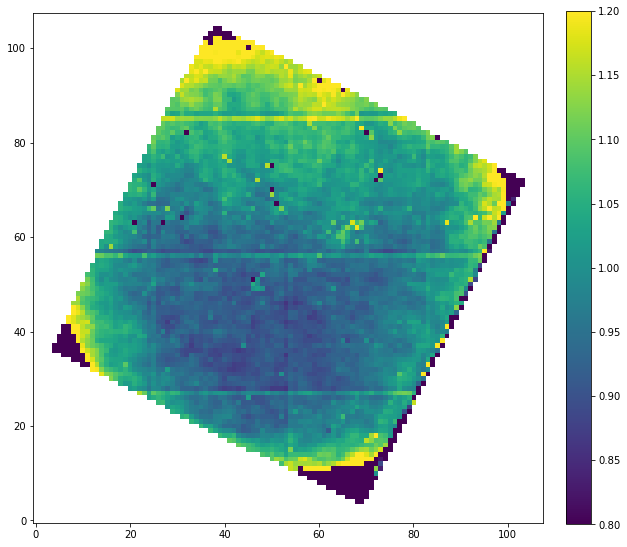

In [11]:
from crispy.tools.imgtools import gen_lenslet_flat
BBcube = Image(par.exportDir+"/BB_red_lstsq.fits")
lenslet_flat,lenslet_mask = gen_lenslet_flat(BBcube)
Image(data = lenslet_flat).write(par.exportDir+"/lenslet_flat.fits")
Image(data = lenslet_mask).write(par.exportDir+"/lenslet_mask.fits")
plt.figure(figsize=(10,10))
plt.imshow(lenslet_flat*lenslet_mask, cmap='viridis',vmin=0.8,vmax=1.2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


crispy - INFO - Read data from HDU 0 of ../../../crispy/ReferenceFiles/Calibra_170425//hires_psflets_lam605.fits


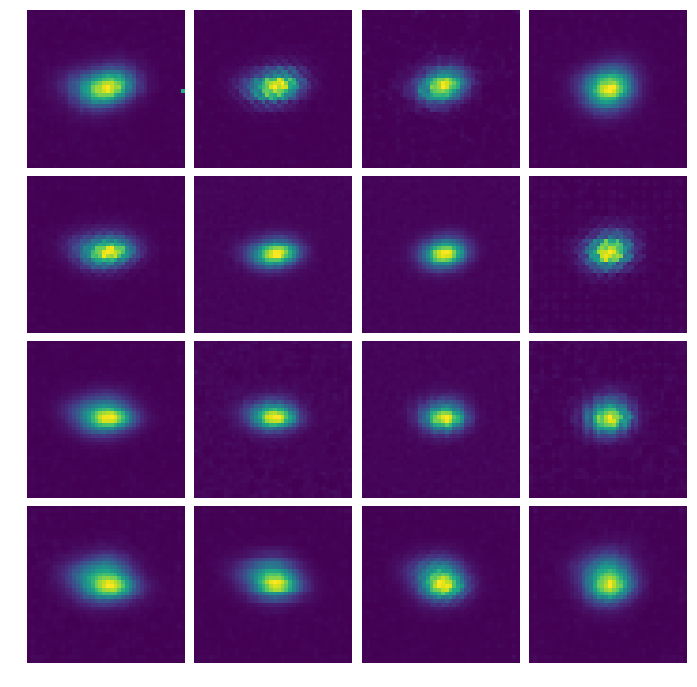

In [30]:
psflets = Image(par.wavecalDir+"/hires_psflets_lam605.fits").data
fig, axarr = plt.subplots(4,4,figsize=(12,12))
for i in range(psflets.shape[0]):
    for j in range(psflets.shape[1]):
        
        axarr[i,j].imshow(psflets[i,j],vmin=0.0)
        axarr[i,j].axis('off')
plt.subplots_adjust(wspace=0.0,hspace=0.05)
plt.savefig(par.wavecalDir+"psflets.png")        
plt.show()


If you are satisfied with the flatfielding and masking, move the two fits files into the wavecal directory and reduce things with the two class attributes defined. When you reload the parameter file, the two attributes automatically get reset.